## Part 1: Exploratory Data Analysis

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

logins_df = pd.read_json('logins.json')

print(logins_df.info())
print(logins_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None
           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21


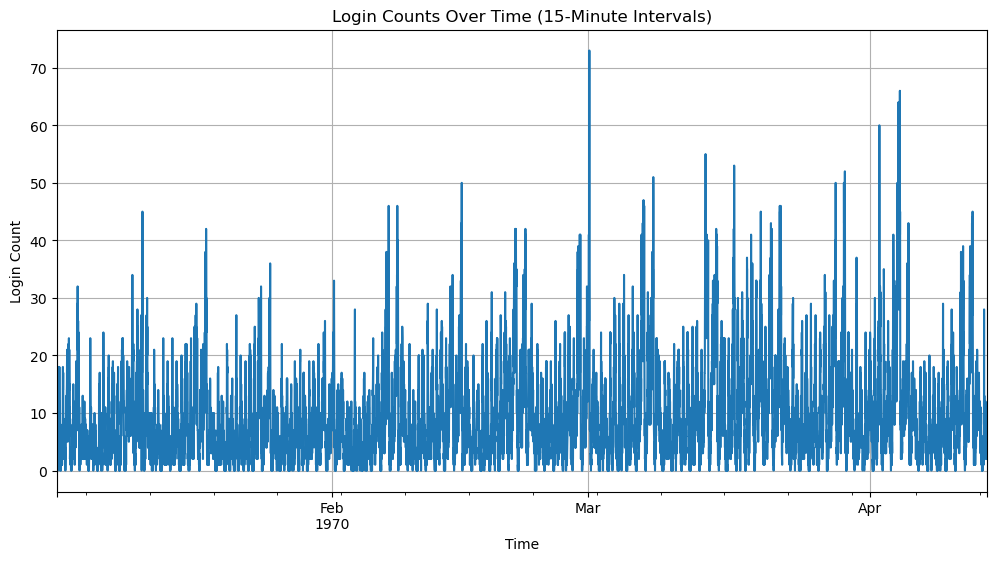

In [7]:
#Convert login_time to datetime and set it as index
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])
logins_df.set_index('login_time', inplace=True)

#Resample data to 15-minute intervals and count logins
logins_count = logins_df.resample('15T').size()

#Visualize time series
plt.figure(figsize=(12, 6))
logins_count.plot()
plt.title('Login Counts Over Time (15-Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.grid(True)
plt.show()

## Part 2: Experiment and Metrics design

1. The key measure of success for encouraging driver partners to serve both cities could be the increase in the number of trips made between the two cities after reimbursing toll costs. This metric directly measures the desired behavior change which is increased cross-city trips.

 2.

Implemetation, Statistical test and Interpretation

In [8]:
from scipy.stats import ttest_ind

np.random.seed(42)

#Generate random data for the experiment
n_samples = 1000
toll_reimbursed = np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])  # 0:Not reimbursed, 1:Reimbursed
cross_city_trips = np.random.randint(0, 10, size=n_samples)  # Number of cross-city trips made by each driver
data = pd.DataFrame({'Toll_Reimbursed': toll_reimbursed, 'Cross_City_Trips': cross_city_trips})

#Experiment
control_group = data[data['Toll_Reimbursed'] == 0]['Cross_City_Trips']
experimental_group = data[data['Toll_Reimbursed'] == 1]['Cross_City_Trips']

#Statistical test: Independent t-test
t_stat, p_value = ttest_ind(control_group, experimental_group)

#Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference between the mean number of cross-city trips "
          "in the control and experimental groups.")
    print("Recommendation: Reimbursing toll costs would encourage driver partners to serve both cities.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference between the mean number of cross-city trips "
          "in the control and experimental groups.")
    print("Recommendation: Reimbursing toll costs may not have a significant impact on encouraging "
          "driver partners to serve both cities.")

Fail to reject the null hypothesis.
There is no significant difference between the mean number of cross-city trips in the control and experimental groups.
Recommendation: Reimbursing toll costs may not have a significant impact on encouraging driver partners to serve both cities.


## Part 3: Predictive Modeling

1. Data Cleaning

In [9]:
ultimate_df = pd.read_json('ultimate_data_challenge.json')

#Check for missing values
print(ultimate_df.isnull().sum())

print(ultimate_df.dtypes)

#Convert date columns to datetime
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

#Calculate retention rate
active_users = ultimate_df['last_trip_date'] >= (ultimate_df['signup_date'] + pd.Timedelta('30 days'))
retention_rate = active_users.mean()
print("Fraction of observed users retained:", retention_rate)


city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64
city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object
Fraction of observed users retained: 0.74258


2. Predictive model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

#Impute missing values
imputer = SimpleImputer(strategy='mean')
ultimate_df['avg_rating_of_driver'] = imputer.fit_transform(ultimate_df[['avg_rating_of_driver']])
ultimate_df['avg_rating_by_driver'] = imputer.fit_transform(ultimate_df[['avg_rating_by_driver']])

#Drop missing values for 'phone' column
ultimate_df.dropna(subset=['phone'], inplace=True)

#Convert date columns to datetime
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

#Calculate retention status (active in 6th month)
six_month_cutoff = ultimate_df['signup_date'] + pd.DateOffset(months=6)
ultimate_df['active_6th_month'] = (ultimate_df['last_trip_date'] >= six_month_cutoff).astype(int)

#Select features and target variable
features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'surge_pct', 
            'avg_surge', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct']
X = ultimate_df[features]
y = ultimate_df['active_6th_month']

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.9996976111279104
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9918
           1       0.00      0.00      0.00         3

    accuracy                           1.00      9921
   macro avg       0.50      0.50      0.50      9921
weighted avg       1.00      1.00      1.00      9921



C:\Users\munae\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\munae\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\munae\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3. Ultimate might leverage the insights gained from the model to improve its long term rider rentention by maybe using different incentives to encourage more trips from the riders in the first month. They could also fond ways to promote the riders or given them better support as a whole when it comes to a certain amount of time that they will be on the road for.